In [100]:
import pandas as pd
import glob
import os
import re
import sys
import ast
from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [30]:
#read files and save the labels to lists
def readFiles(dir):
    dataAll_df = pd.read_csv(dir,index_col=None, header=0)
    utt = dataAll_df['utt'].to_list()
    utt = [i.strip() for i in utt]
    tokens = dataAll_df['tokenized'].to_list()
    clean_tokens = [ast.literal_eval(i) for i in tokens]
    return list(zip(utt, clean_tokens)), utt


In [48]:
Odin, Odin_utt = readFiles("metadata2tokenzied.csv")
Golden, Golden_utt = readFiles("cleanAnnotation.csv")

In [50]:
#select the Vers-3 data from Odin(Vers-6)
OdinDict = {}
for i in Odin:
    OdinDict[i[0]] = i[1]
selected_Odin = []
for i in range(len(Golden_utt)):
    if Golden_utt[i] in OdinDict:
        selected_Odin.append((Golden_utt[i],OdinDict[Golden_utt[i]]))
Odin = selected_Odin

In [51]:
#check if all the utterances matched
count = 0
for i in range(len(Odin)):
    if Odin[i][0] != Golden[i][0]:
        count += 1
count

0

In [52]:
#get the label tokens
OdinTokens = [i[1] for i in Odin]
GoldenTokens = [i[1] for i in Golden]

In [54]:
#convert label tokens to a single list
OT = []
GT = []
for i in range(len(OdinTokens)):
    len1,len2 = len(OdinTokens[i]),len(GoldenTokens[i])
    #padding 0 to shorter lists
    if len1 > len2:
        r2 = GoldenTokens[i] + (len1-len2) * [0]
        r1 = OdinTokens[i]
    elif len2 > len1:
        r1 = OdinTokens[i] + (len2-len1) * [0]
        r2 = GoldenTokens[i]
    else:
        r1,r2 = OdinTokens[i], GoldenTokens[i]
    #deal with overlap
    overlap = Counter(r1) & Counter(r2)
    for j in overlap:
        OT += [j] * overlap[j]
        GT += [j] * overlap[j]
        r1.remove(j)
        r2.remove(j)
    for k in r1:
        OT.append(k)
    for l in r2:
        GT.append(l)

In [59]:
conf_matrix = confusion_matrix(y_true=GT, y_pred=OT)

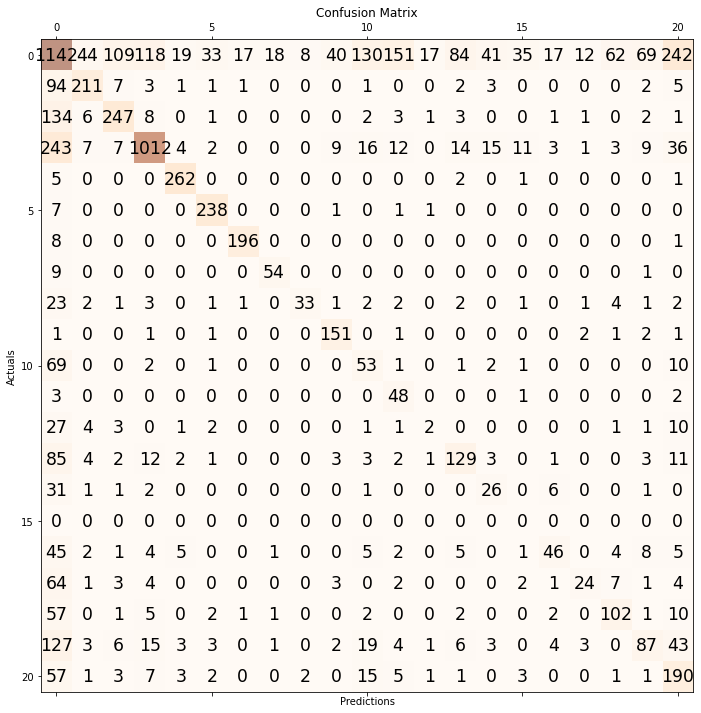

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

In [85]:
accuracy = accuracy_score(GT, OT)
recall = recall_score(GT, OT, average='weighted',zero_division=1)
precision = precision_score(GT, OT, average='weighted')
f1 = f1_score(GT, OT, average='weighted')

In [81]:
print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1:", f1)

accuracy: 0.5892213909670269
recall: 0.5892213909670269
precision: 0.6184864798621198
f1: 0.5939509568751832


In [103]:
#token event groups

def reTokenize(data):
    data2 = []
    for i in range(len(data)):
        if data[i] in list(range(1,10)):
            data2.append(1)
        elif data[i] in list(range(10,21)):
            data2.append(2)
        else:
            data2.append(0)
    return data2
OT2 = reTokenize(OT)
GT2 = reTokenize(GT)


In [204]:
overall = metrics.classification_report(GT, OT, digits=3, zero_division=1)
print(overall)

              precision    recall  f1-score   support

           0      0.512     0.474     0.492      2408
           1      0.738     0.637     0.684       331
           2      0.632     0.602     0.617       410
           3      0.846     0.721     0.778      1404
           4      0.873     0.967     0.918       271
           5      0.826     0.960     0.888       248
           6      0.907     0.956     0.931       205
           7      0.720     0.844     0.777        64
           8      0.767     0.412     0.537        80
           9      0.719     0.938     0.814       161
          10      0.212     0.379     0.272       140
          11      0.204     0.889     0.332        54
          12      0.083     0.038     0.052        53
          13      0.514     0.492     0.503       262
          14      0.280     0.377     0.321        69
          15      0.000     1.000     0.000         0
          16      0.568     0.343     0.428       134
          17      0.545    

In [106]:
grouped = metrics.classification_report(GT2, OT2, digits=3)
print(grouped)

              precision    recall  f1-score   support

           0      0.512     0.474     0.492      2408
           1      0.823     0.779     0.800      3174
           2      0.477     0.578     0.522      1636

    accuracy                          0.632      7218
   macro avg      0.604     0.610     0.605      7218
weighted avg      0.641     0.632     0.635      7218



In [ ]:
labels = {'0':0,
"CriticalVictim":1,
'Victim':2,
'Room':3,
'Engineer':4,
'Transporter':5,
'Medic':6,
'Rubble':7,
'MarkerBlock':8,
'Meeting':9,
'Move':10,
'Precedence':11,
'RescueInteractions':12,
'KnowledgeSharing':13,
'ReportLocation':14,
'Search':15,
'HelpRequest':16,
'Question':17,
'YesNoQuestion':18,
'Instruction':19,
'Plan':20
}
reverseLabels = {}
for key,value in labels.items():
    reverseLabels[value] = key

In [135]:
groupedLabels = {
    0: "0",
    1: "Token Labels",
    2: "Event Labels"
}

In [168]:
# print the results
## Grouped labels
results = []
lines = grouped.strip().split("\n")
headers = lines[0].split("  ")
headers = [i.strip() for i in headers]
headers.remove("")
lines.remove("")
lines = lines[1:4]
for line in lines:
    scores = line.strip().split("     ")
    scores = [i.strip() for i in scores]
    results.append([groupedLabels[int(scores[0])]] + scores[1:])
headers = ["group"] + headers
grouped_df = pd.DataFrame(results, columns=headers)
grouped_df

,group,precision,recall,f1-score,support
0,0,0.512,0.474,0.492,2408
1,Token Labels,0.823,0.779,0.800,3174
2,Event Labels,0.477,0.578,0.522,1636


In [205]:
# print the results
## overall results
results = []
lines = overall.strip().split("\n")
headers = lines[0].split("  ")
headers = [i.strip() for i in headers]
headers.remove("")
lines.remove("")
lines =lines[-3:]
for line in lines:
     scores = line.strip().split("     ")
     scores = [i.strip() for i in scores]
     if "" in scores:
        scores.remove("")
        scores.remove("")
     results.append(scores)
headers = ["      "] + headers
overall_df = pd.DataFrame(results, columns=headers)
overall_df

,,precision,recall,f1-score,support
0,accuracy,,,0.589,7218
1,macro avg,0.538,0.605,0.522,7218
2,weighted avg,0.618,0.589,0.594,7218


In [206]:
# print the results
## individual label results
results = []
lines = overall.strip().split("\n")
headers = lines[0].split("  ")
headers = [i.strip() for i in headers]
headers.remove("")
lines.remove("")
lines = lines[1:22]
for line in lines:
     scores = line.strip().split("     ")
     scores = [i.strip() for i in scores]
     results.append([reverseLabels[int(scores[0])]] + scores[1:])   
headers = ["group"] + headers
individual_df = pd.DataFrame(results, columns=headers)
individual_df

,group,precision,recall,f1-score,support
0,0,0.512,0.474,0.492,2408
1,CriticalVictim,0.738,0.637,0.684,331
2,Victim,0.632,0.602,0.617,410
3,Room,0.846,0.721,0.778,1404
4,Engineer,0.873,0.967,0.918,271
5,Transporter,0.826,0.960,0.888,248
6,Medic,0.907,0.956,0.931,205
7,Rubble,0.720,0.844,0.777,64
8,MarkerBlock,0.767,0.412,0.537,80
9,Meeting,0.719,0.938,0.814,161
